<a href="https://colab.research.google.com/github/Justin-Jonany/IndoFoodNet/blob/main/5_model_training_efficientnetv2_b3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IndoFoodNet
IndoFoodNet aims to create a neural networks model that correctly classifies images of 9 differet Padang food. The dataset is taken from https://www.kaggle.com/datasets/faldoae/padangfood.

</br>

This notebook aims to create models to classify images into the correct labels based on **EfficientNetV2B3**

## Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import os

## Helper Functions

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
  plt.show()



def compare_historys(original_history, new_history, initial_epochs):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Load Data

In [ ]:
path = '/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/processed_data/b3_'
train_data = tf.data.Dataset.load(path + 'train_data')
test_data = tf.data.Dataset.load(path + 'test_data')
val_data = tf.data.Dataset.load(path + 'val_data')

In [ ]:
train_data.element_spec

(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))

In [ ]:
train_dir = '/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/splitted_data/train/'
class_names = os.listdir(train_dir)

## Creating Callbacks

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=4)

# Set checkpoint path
checkpoint_path = 'checkpoints/checkpoint'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq='epoch', # Save every epoch
                                                         verbose=1)



## Setup mixed prevision training

In [ ]:
# Turn on mixed prevision training
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision
mixed_precision.global_policy()

<Policy "mixed_float16">

## Base Model

In [ ]:
input_shape = (300, 300, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name='input_layer')

metrics = [tf.keras.metrics.F1Score(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           'accuracy'
          ]

52606240/52606240 [==============================] - 3s 0us/step


In [ ]:
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model_0 = tf.keras.Model(inputs, outputs)


# Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=metrics
                )

In [ ]:
history_0 = model_0.fit(train_data,
                        epochs=50,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        callbacks=[early_stopping]
                        )

Epoch 1/50
21/21 [==============================] - 39s 783ms/step - loss: 1.6928 - f1_score: 0.4984 - precision: 0.8182 - recall: 0.0139 - accuracy: 0.5093 - val_loss: 1.1987 - val_f1_score: 0.7438 - val_precision: 1.0000 - val_recall: 0.1111 - val_accuracy: 0.7444
Epoch 2/50
21/21 [==============================] - 3s 130ms/step - loss: 0.9098 - f1_score: 0.8634 - precision: 0.9910 - recall: 0.3410 - accuracy: 0.8642 - val_loss: 0.8240 - val_f1_score: 0.8225 - val_precision: 0.9565 - val_recall: 0.4889 - val_accuracy: 0.8222
Epoch 3/50
21/21 [==============================] - 4s 195ms/step - loss: 0.6075 - f1_score: 0.9117 - precision: 0.9797 - recall: 0.6698 - accuracy: 0.9120 - val_loss: 0.6627 - val_f1_score: 0.8338 - val_precision: 0.9394 - val_recall: 0.6889 - val_accuracy: 0.8333
Epoch 4/50
21/21 [==============================] - 3s 132ms/step - loss: 0.4659 - f1_score: 0.9336 - precision: 0.9809 - recall: 0.7932 - accuracy: 0.9336 - val_loss: 0.5757 - val_f1_score: 0.8338 - v

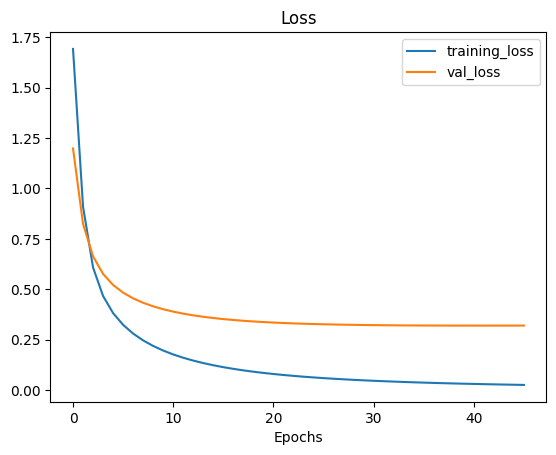

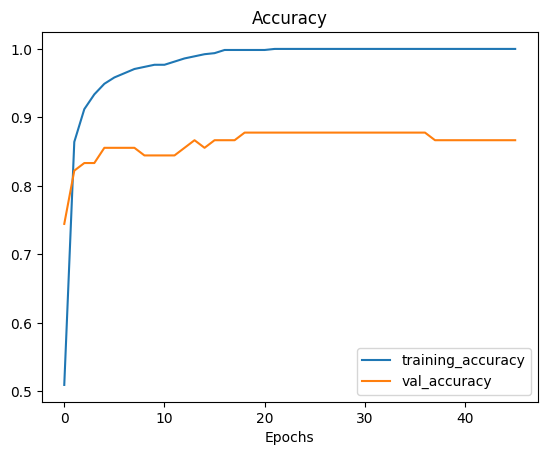

In [ ]:
plot_loss_curves(history_0)

It seems our model is overfitting

In [ ]:
model_0.evaluate(val_data)

3/3 [==============================] - 0s 101ms/step - loss: 0.3192 - f1_score: 0.8674 - precision: 0.9277 - recall: 0.8556 - accuracy: 0.8667


[0.319230854511261,
 array([0.84210527, 0.8571428 , 0.8571428 , 0.9473684 , 0.76190484,
        0.8571428 , 0.73684216, 0.9473684 , 1.        ], dtype=float32),
 0.9277108311653137,
 0.855555534362793,
 0.8666666746139526]

In [ ]:
model_0.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b3/model_0')

## Model 1: Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name='data_augmentation')

In [ ]:
x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=metrics,
                )

In [ ]:
history_1 = model_1.fit(train_data,
                        epochs=50,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        callbacks=[early_stopping]
                        )

Epoch 1/50
21/21 [==============================] - 37s 248ms/step - loss: 1.7996 - f1_score: 0.6409 - precision: 0.9699 - recall: 0.3612 - accuracy: 0.4182 - val_loss: 1.2743 - val_f1_score: 0.6892 - val_precision: 1.0000 - val_recall: 0.0778 - val_accuracy: 0.7000
Epoch 2/50
21/21 [==============================] - 3s 133ms/step - loss: 0.9550 - f1_score: 0.8479 - precision: 0.9845 - recall: 0.2932 - accuracy: 0.8488 - val_loss: 0.8615 - val_f1_score: 0.7994 - val_precision: 0.9756 - val_recall: 0.4444 - val_accuracy: 0.8000
Epoch 3/50
21/21 [==============================] - 4s 188ms/step - loss: 0.6338 - f1_score: 0.8979 - precision: 0.9795 - recall: 0.6636 - accuracy: 0.8981 - val_loss: 0.6874 - val_f1_score: 0.8123 - val_precision: 0.9833 - val_recall: 0.6556 - val_accuracy: 0.8111
Epoch 4/50
21/21 [==============================] - 3s 133ms/step - loss: 0.4856 - f1_score: 0.9246 - precision: 0.9790 - recall: 0.7932 - accuracy: 0.9244 - val_loss: 0.5956 - val_f1_score: 0.8352 - v

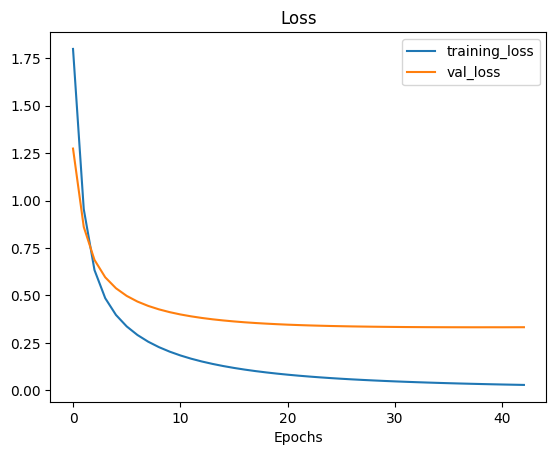

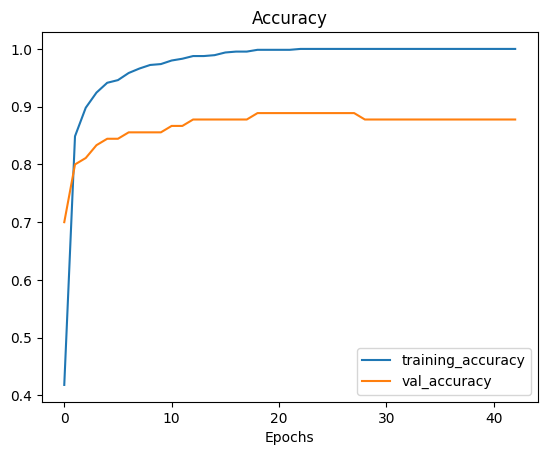

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_1.evaluate(val_data)

3/3 [==============================] - 0s 98ms/step - loss: 0.3325 - f1_score: 0.8782 - precision: 0.8941 - recall: 0.8444 - accuracy: 0.8778


[0.3325209617614746,
 array([0.9       , 0.90909094, 0.9       , 0.9473684 , 0.8000001 ,
        0.8000001 , 0.7       , 0.9473684 , 1.        ], dtype=float32),
 0.8941176533699036,
 0.8444444537162781,
 0.8777777552604675]

In [ ]:
model_0.evaluate(val_data)

3/3 [==============================] - 0s 101ms/step - loss: 0.3192 - f1_score: 0.8674 - precision: 0.9277 - recall: 0.8556 - accuracy: 0.8667


[0.319230854511261,
 array([0.84210527, 0.8571428 , 0.8571428 , 0.9473684 , 0.76190484,
        0.8571428 , 0.73684216, 0.9473684 , 1.        ], dtype=float32),
 0.9277108311653137,
 0.855555534362793,
 0.8666666746139526]

It seems that data augmentation improve our model's f1-score and accuracy, but not the loss hmmmmm

In [ ]:
model_1.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b3/model_1')

## Model 2: Fine Tuning on the base model with no data augmentation


Let's unfreeze the first 10 layers for this model

In [ ]:
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b3/model_0')

In [ ]:
model_2.layers

In [ ]:
model_2.layers[1].trainable = True
for layer in model_2.layers[1].layers[:-10]:
  layer.trainable = False

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=metrics)

In [ ]:
fine_tune_epochs = history_0.epoch[-1] + 50
checkpoint_callback.filepath = 'checkpoint/model_2'
history_2 = model_2.fit(train_data,
                        epochs=fine_tune_epochs,
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        initial_epoch=history_0.epoch[-1],
                        callbacks=[early_stopping,
                                   checkpoint_callback]
                        )

Epoch 46/95
20/21 [===========================>..] - ETA: 0s - loss: 0.0189 - f1_score: 0.9835 - precision: 0.9917 - recall: 0.9822 - accuracy: 1.0000
Epoch 46: val_loss improved from inf to 0.34560, saving model to checkpoint/model_2
21/21 [==============================] - 21s 349ms/step - loss: 0.0187 - f1_score: 0.9838 - precision: 0.9918 - recall: 0.9824 - accuracy: 1.0000 - val_loss: 0.3456 - val_f1_score: 0.8687 - val_precision: 0.8941 - val_recall: 0.8444 - val_accuracy: 0.8667
Epoch 47/95
20/21 [===========================>..] - ETA: 0s - loss: 0.0072 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000
Epoch 47: val_loss did not improve from 0.34560
21/21 [==============================] - 3s 135ms/step - loss: 0.0072 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000 - val_loss: 0.3804 - val_f1_score: 0.8794 - val_precision: 0.8851 - val_recall: 0.8556 - val_accuracy: 0.8778
Epoch 48/95
20/21 [===========================>..] - ET

In [ ]:
model_2.evaluate(val_data)

3/3 [==============================] - 0s 104ms/step - loss: 0.3857 - f1_score: 0.8674 - precision: 0.8851 - recall: 0.8556 - accuracy: 0.8667


[0.3857293128967285,
 array([0.88888896, 0.90909094, 0.8571428 , 0.9473684 , 0.7       ,
        0.8571428 , 0.7       , 0.9473684 , 1.        ], dtype=float32),
 0.8850574493408203,
 0.855555534362793,
 0.8666666746139526]

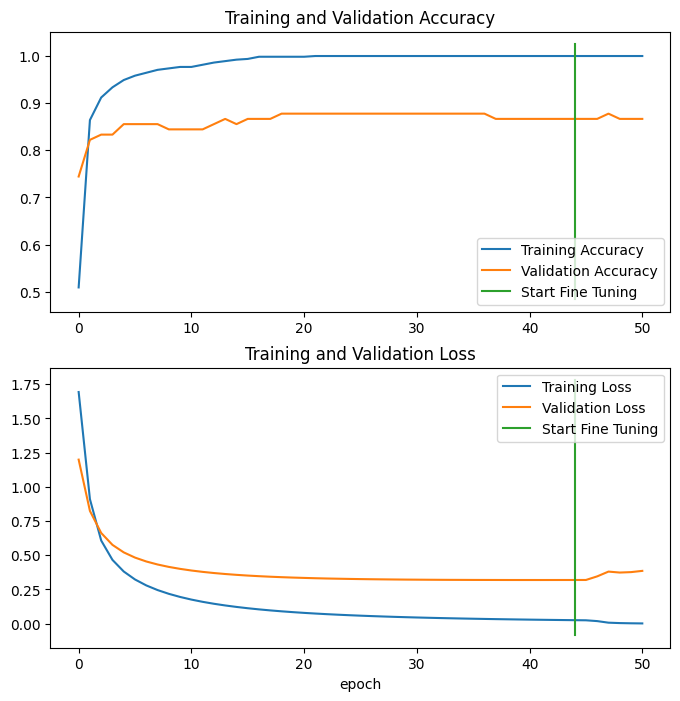

In [ ]:
compare_historys(history_0, history_2, history_0.epoch[-1])

In [ ]:
model_2.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b3/model_2')

Hmmmm, it seems model_2 is not performing well.

## Model 3: data augmentation and fine-tuning
fine-tuning 10 layers

In [ ]:
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b3/model_1')

In [ ]:
model_3.layers[1].trainable = True
for layer in model_3.layers[1].layers[:-10]:
  layer.trainable = False

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=metrics)

In [ ]:
fine_tune_epochs = history_1.epoch[-1] + 50

checkpoint_callback.filepath = 'checkpoint/model_3'

history_3 = model_3.fit(train_data,
                        epochs=fine_tune_epochs,
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        initial_epoch=history_1.epoch[-1],
                        callbacks=[early_stopping, checkpoint_callback]
                        )

Epoch 43/92
20/21 [===========================>..] - ETA: 0s - loss: 0.0215 - f1_score: 0.9835 - precision: 0.9862 - recall: 0.9822 - accuracy: 1.0000
Epoch 43: val_loss did not improve from 0.34560
21/21 [==============================] - 20s 323ms/step - loss: 0.0213 - f1_score: 0.9838 - precision: 0.9864 - recall: 0.9824 - accuracy: 1.0000 - val_loss: 0.3678 - val_f1_score: 0.8795 - val_precision: 0.8864 - val_recall: 0.8667 - val_accuracy: 0.8778
Epoch 44/92
20/21 [===========================>..] - ETA: 0s - loss: 0.0080 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000
Epoch 44: val_loss did not improve from 0.34560
21/21 [==============================] - 3s 132ms/step - loss: 0.0079 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000 - val_loss: 0.4047 - val_f1_score: 0.8808 - val_precision: 0.8966 - val_recall: 0.8667 - val_accuracy: 0.8778
Epoch 45/92
20/21 [===========================>..] - ETA: 0s - loss: 0.0048 - f1_score: 1.0

In [ ]:
model_3.evaluate(val_data)

3/3 [==============================] - 1s 152ms/step - loss: 0.4141 - f1_score: 0.8792 - precision: 0.8864 - recall: 0.8667 - accuracy: 0.8778


[0.4140549600124359,
 array([0.9473684 , 0.90909094, 0.9       , 0.9473684 , 0.76190484,
        0.8000001 , 0.7       , 0.9473684 , 1.        ], dtype=float32),
 0.8863636255264282,
 0.8666666746139526,
 0.8777777552604675]

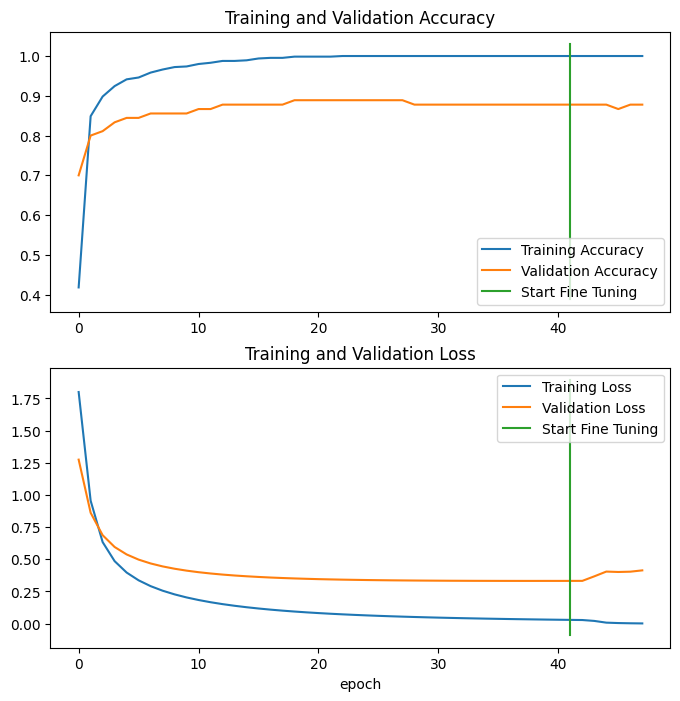

In [ ]:
compare_historys(history_1, history_3, history_1.epoch[-1])

In [ ]:
model_3.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b3/model_3')

Hmmmm it seems model_3 is not doing well

It seems our model is no longer performing well, so we will conclude this notebook on model training on **EfficientNetV2B3**

In [ ]:
model_0_scores = model_0.evaluate(val_data)
model_1_scores = model_1.evaluate(val_data)
model_2_scores = model_2.evaluate(val_data)
model_3_scores = model_3.evaluate(val_data)

3/3 [==============================] - 0s 93ms/step - loss: 0.4141 - f1_score: 0.8792 - precision: 0.8864 - recall: 0.8667 - accuracy: 0.8778


In [ ]:
print(f'model_0:\n loss: {model_0_scores[0]} \n accuracy: {model_0_scores[4]}')
print(f'model_1:\n loss: {model_1_scores[0]} \n accuracy: {model_1_scores[4]}')
print(f'model_2:\n loss: {model_2_scores[0]} \n accuracy: {model_2_scores[4]}')
print(f'model_3:\n loss: {model_3_scores[0]} \n accuracy: {model_3_scores[4]}')

model_0:
 loss: 0.319230854511261 
 accuracy: 0.8666666746139526
model_1:
 loss: 0.3325209617614746 
 accuracy: 0.8777777552604675
model_2:
 loss: 0.3857293128967285 
 accuracy: 0.8666666746139526
model_3:
 loss: 0.4140549600124359 
 accuracy: 0.8777777552604675


In [ ]:
model_0_scores[1] = model_0_scores[1].mean()
model_1_scores[1] = model_1_scores[1].mean()
model_2_scores[1] = model_2_scores[1].mean()
model_3_scores[1] = model_3_scores[1].mean()

loss = pd.DataFrame({'model_0': model_0_scores,
                         'model_1': model_1_scores,
                         'model_2': model_2_scores,
                         'model_3': model_3_scores,
                         }, index=['loss', 'f1-score', 'precision', 'recall', 'accuracy'])
loss = loss.T
loss

,loss,f1-score,precision,recall,accuracy
model_0,0.319231,0.867446,0.927711,0.855556,0.866667
model_1,0.332521,0.878203,0.894118,0.844444,0.877778
model_2,0.385729,0.867445,0.885057,0.855556,0.866667
model_3,0.414055,0.879233,0.886364,0.866667,0.877778


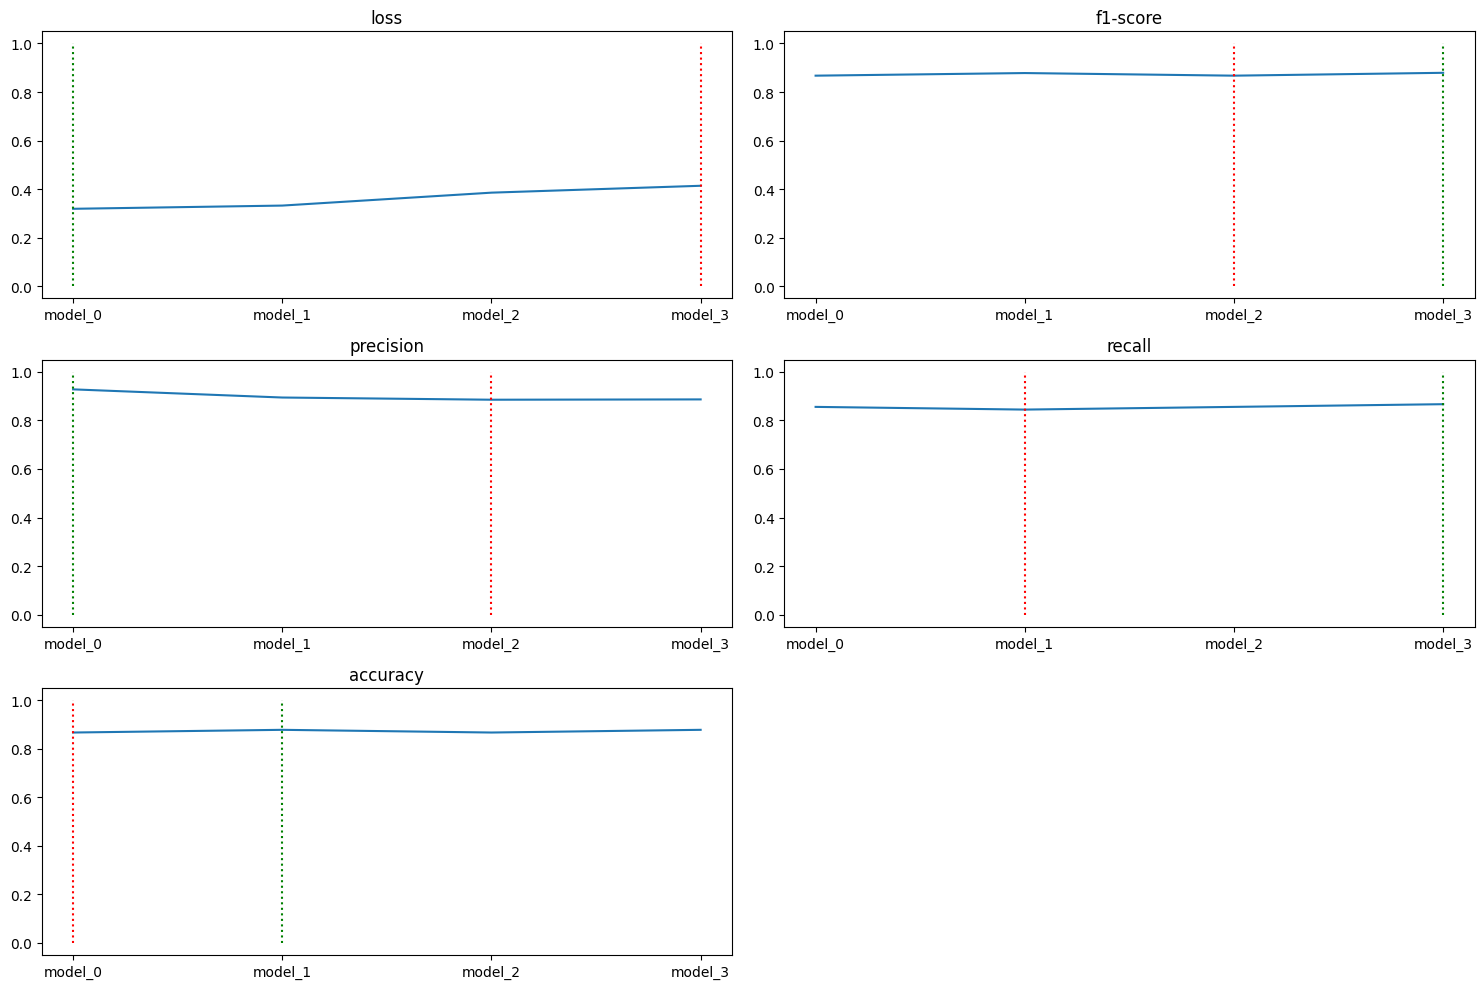

In [ ]:
fig = plt.figure(figsize=(15, 10))
for i, index in enumerate(loss.columns):
  plt.subplot(3, 2, 1 + i)
  plt.plot(loss[index])
  plt.title(index)
  if index == 'loss':
    plt.vlines(loss.index[loss[index].argmax()], 0, 1, color='red', linestyles='dotted')
    plt.vlines(loss.index[loss[index].argmin()], 0, 1, color='green', linestyles='dotted')
  else:
    plt.vlines(loss.index[loss[index].argmax()], 0, 1, color='green', linestyles='dotted')
    plt.vlines(loss.index[loss[index].argmin()], 0, 1, color='red', linestyles='dotted')

fig.tight_layout()

It seems that the results are very similar, but the model with lowest loss is model_1 and the one with the best f1-score is model_3. But model_3 seems to have the worst loss.

In [ ]:
model_0.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/best_model_per_version/efficientnetv2b3_fine_tuned')